# Estimativa de pontos de estória usando aprendizado profundo

Utilização de aprendizado profundo por redes neurais.

In [220]:
import os
import gzip
import pickle
import random

import numpy as np
import pandas as pd

import spacy
#os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
import theano
from keras.layers import Input, Embedding, LSTM

from collections import defaultdict

#nlp = spacy.load('pt', disable=['parser', 'tagger', 'ner'])
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
#tokenizar = spacy.tokenizer.Tokenizer(nlp.vocab)

## Divisão do conjunto de dados

Treino, validação e teste.

In [125]:
def ler_csv_texto_tokenizado(caminho_arquivo, tokenizador):
    tabela_dados = pd.read_csv(caminho_arquivo)
    titulos = tabela_dados.values[:, 1].astype('str')
    separadores = np.full(len(titulos), '. ')
    descricao = tabela_dados.values[:, 2].astype('str')
    valores = tabela_dados.values[:, 3].astype('float32')
    juntos = [a + b + c for a, b, c in zip(titulos, separadores, descricao)]
    tokenizados = [[w.text.strip().lower() for w in tokenizador(frase) if not w.text.isspace()] for frase in juntos]
    return tokenizados, valores

def gerar_dicionario(lista_tokens, vocabulario_maximo=500):
    contagem = defaultdict(int)
    for tokens in lista_tokens:
        for token in tokens:
            contagem[token] += 1
    ordenadas = sorted(contagem.items(), key=lambda x: x[1], reverse=True)
    IDs = {'EOF_VALUE': 0, 'UNK_VALUE': 1}
    for i in range(min(vocabulario_maximo, len(ordenadas))): # EOF = 0, ID_desconhecido = 1
        IDs[ordenadas[i][0]] = i + 2
    return IDs

def converte_tokens_pretreino(lista_tokens, dic): #, fracao_valida = 0.2):
    dados = [np.array([(dic.get(tk) or 1) for tk in tks], dtype=np.int16) for tks in lista_tokens]
    #quant_valida = int(fracao_valida * len(lista_tokens))
    return dados #[:-quant_valida], dados[-quant_valida:]

def converte_tokens_treino(lista_tokens, dic, fracao_valida = 0.2, fracao_teste = 0.2, tamanho_frase=256):
    dados = np.zeros((len(lista_tokens), tamanho_frase), dtype='int16')
    for i, tks in enumerate(lista_tokens):
        compri = min(tamanho_frase, len(tks))
        dados[i, :compri] = [(dic.get(tks[i]) or 1) for i in range(compri)]
    quant_valida = int(fracao_valida * len(lista_tokens))
    quant_teste = int(fracao_teste * len(lista_tokens))
    return dados[:-quant_valida-quant_teste], dados[-quant_valida-quant_teste:-quant_teste], dados[-quant_teste:]

In [126]:
#a = ler_csv_texto_tokenizado('dados/pretreino/ccasj.csv', nlp.tokenizer)
a, valores = ler_csv_texto_tokenizado('dados/pretreino/lsscorp_pretreino.csv', nlp.tokenizer)
dic = gerar_dicionario(a)
#treino, validacao = converte_tokens_pretreino(a, dic)
treino = converte_tokens_pretreino(a, dic)
print('Vocabulario: ', len(dic), '\nTreino: ', len(treino))#, '\n Validação: ', len(validacao))

Vocabulario:  18268 
Treino:  2452


In [213]:
train_text, train_points = ler_csv_texto_tokenizado('dados/treino/datamanagement.csv', nlp.tokenizer)
x_train, x_val, x_test = converte_tokens_treino(train_text, dic)
y_train = train_points[:x_train.shape[0]].reshape((-1, 1))
y_val = train_points[x_train.shape[0]:x_train.shape[0]+x_val.shape[0]].reshape((-1, 1))
y_test = train_points[x_train.shape[0] + x_val.shape[0]:].reshape((-1, 1))
print('Train: ', x_train.shape[0], '\nValidation: ', x_val.shape[0], '\nTest: ', x_test.shape[0])

Train:  2801 
Validation:  933 
Test:  933


In [219]:
np.mean(np.abs(np.median(y_train) - y_test))

6.19507

In [222]:
f = gzip.open('dados/treino/datamanagement.pkl.gz', 'rb')

train_t, train_d, train_y, \
valid_t, valid_d, valid_y, \
test_t, test_d, test_y = pickle.load(f, encoding='latin1')

In [236]:
valid_y.shape

(935,)

In [246]:
valid_y[2:]

array([ 1., 18.,  2., 10.,  4.,  1.,  1.,  2.,  4.,  4.,  5.,  2.,  2.,
        2.,  6., 10.,  2., 21., 21.,  6.,  1.,  1.,  2.,  3., 20.,  6.,
        6., 14.,  4., 10.,  6.,  6.,  5.,  6.,  2.,  4.,  8., 10., 10.,
       10.,  8., 12.,  8.,  2.,  6.,  6.,  4., 12., 18.,  4.,  6.,  3.,
        4.,  1.,  2.,  1.,  1.,  1.,  1.,  4.,  4.,  4.,  2.,  8., 10.,
        5.,  6.,  6., 10.,  5.,  4.,  5.,  6.,  8.,  4.,  1.,  2., 10.,
        4.,  3.,  2.,  1., 21.,  1., 21.,  5.,  3.,  3.,  6.,  2.,  2.,
        6.,  1.,  1.,  8.,  2., 21., 10., 21., 21., 15.,  2., 21.,  8.,
       21., 16., 12., 12., 20., 10., 10., 15.,  4.,  4.,  4.,  2.,  1.,
        1.,  1.,  1.,  1.,  3.,  1.,  2.,  2.,  4.,  2.,  6.,  6.,  2.,
        4.,  2.,  3.,  3.,  3.,  1.,  3., 10.,  2.,  1.,  1.,  3.,  4.,
        5.,  4.,  5.,  5.,  1.,  1.,  2.,  4., 10.,  5.,  2.,  3.,  9.,
        6.,  1.,  3.,  7.,  4., 12.,  8., 10.,  7., 13., 12.,  2.,  2.,
        4.,  2.,  4.,  2.,  2.,  3.,  2.,  2.,  3.,  2.,  1.,  2

In [249]:
y_val[:-2][(valid_y[2:] - y_val[:-2].flatten()) != 0]

array([[ 70.],
       [ 38.],
       [100.],
       [ 60.],
       [ 40.],
       [ 60.],
       [ 25.],
       [ 80.],
       [ 25.],
       [ 38.],
       [ 24.],
       [ 29.],
       [ 50.],
       [ 24.],
       [ 30.],
       [ 50.],
       [ 24.],
       [ 33.],
       [ 73.],
       [ 30.],
       [ 30.],
       [ 65.],
       [ 65.],
       [ 26.],
       [ 65.],
       [ 65.],
       [100.],
       [ 26.],
       [ 26.],
       [ 26.],
       [100.],
       [ 60.],
       [ 45.],
       [ 49.],
       [ 64.],
       [ 28.],
       [100.],
       [ 50.],
       [ 25.],
       [ 25.],
       [ 50.],
       [ 25.],
       [ 32.],
       [ 23.],
       [ 52.],
       [ 43.],
       [ 38.],
       [ 45.],
       [ 30.],
       [100.],
       [100.],
       [ 40.],
       [ 54.],
       [ 23.],
       [ 24.],
       [100.],
       [ 26.],
       [ 22.],
       [ 22.],
       [ 25.],
       [ 40.],
       [100.],
       [ 27.],
       [ 40.],
       [ 54.],
       [ 68.],
       [ 2

## Representação Vetorial do FB FastText

In [1]:
import io

def carrega_vetor(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

vetores = carrega_vetor('word_embeddings/cc.pt.300.vec')

## Pretreinamento

In [120]:
class GeradorDados(keras.utils.Sequence):
    
    def __init__(self, funcoes, tamanho_batch=128, quant_batch=100, janela=7, fracao_positiva=0.5):
        self.funcoes = funcoes
        self.tamanho_batch = tamanho_batch
        self.quant_batch = quant_batch
        self.janela = janela
        self.fracao_positiva = fracao_positiva
        self.quant_funcoes = len(funcoes)
    
    def __len__(self):
        return self.quant_batch
    
    def __getitem__(self, idx):
        alvo = np.zeros((self.tamanho_batch, 1), dtype='int16')
        contexto = np.zeros((self.tamanho_batch, 1), dtype='int16')
        verdade = np.zeros((self.tamanho_batch, 1))
        for i in range(self.tamanho_batch):
            positivo = random.random() < self.fracao_positiva
            j = random.randint(0, self.quant_funcoes - 1)
            k = random.randint(0, self.funcoes[j].shape[0] - 1)
            if positivo:
                l = j
                m = random.randint(max(0, k-self.janela), min(self.funcoes[j].shape[0] - 1, k+self.janela))
            else:
                l = random.randint(0, self.quant_funcoes - 1)
                m = random.randint(0, self.funcoes[l].shape[0] - 1)
            alvo[i] = self.funcoes[j][k]
            contexto[i] = self.funcoes[l][m]
            verdade[i] = positivo
        return [alvo, contexto], verdade

def gerar_modelo_keras(vocabulario, dimensao_vetorial=50):
    entrada_contexto = keras.layers.Input(shape=(1,), dtype='int16', name='palavra_contexto')
    entrada_alvo = keras.layers.Input(shape=(1,), dtype='int16', name='palavra_alvo')
    vetorizacao = keras.layers.Embedding(vocabulario, dimensao_vetorial, name='vetorizacao')
    contexto = keras.layers.Flatten()(vetorizacao(entrada_contexto))
    alvo = keras.layers.Flatten()(vetorizacao(entrada_alvo))
    produto_interno = keras.layers.dot([alvo, contexto], axes=-1)
    estimativa = keras.layers.Dense(1, activation='sigmoid')(produto_interno)
    return keras.models.Model(inputs=[entrada_alvo, entrada_contexto], outputs=estimativa)

In [127]:
gerador_treino = GeradorDados(treino, 128, 128)
gerador_valida = GeradorDados(validacao, 128, 8)
mod_emb = gerar_modelo_keras(len(dic))
mod_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
palavra_alvo (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
palavra_contexto (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
vetorizacao (Embedding)         (None, 1, 50)        913400      palavra_contexto[0][0]           
                                                                 palavra_alvo[0][0]               
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 50)           0           vetorizacao[1][0]                
__________

In [128]:
mod_emb.compile(loss='binary_crossentropy',optimizer='adam')

In [165]:
csv_logger = keras.callbacks.CSVLogger('logs/pretreino.log')
parar_mlp = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
salvar_mlp = keras.callbacks.ModelCheckpoint('logs/pretreino.h5', monitor='val_loss', mode='min', save_best_only=True)

historico3 = mod_emb.fit_generator(generator=gerador_treino, steps_per_epoch=128, epochs=50, use_multiprocessing=True, shuffle=False, workers=32, max_queue_size=64, validation_data=gerador_valida, validation_steps=8)

Epoch 1/50
127/128 [============================>.] - ETA: 0s - loss: 0.5801Epoch 1/50
Epoch 1/50
128/128 [==============================] - 11s 84ms/step - loss: 0.5800 - val_loss: 0.6410
Epoch 2/50
128/128 [==============================] - 10s 82ms/step - loss: 0.5803 - val_loss: 0.6326
Epoch 3/50
128/128 [==============================] - 10s 80ms/step - loss: 0.5804 - val_loss: 0.6074
Epoch 4/50
128/128 [==============================] - 11s 87ms/step - loss: 0.5828 - val_loss: 0.6273
Epoch 5/50
128/128 [==============================] - 12s 91ms/step - loss: 0.5775 - val_loss: 0.6016
Epoch 6/50
128/128 [==============================] - 11s 85ms/step - loss: 0.5793 - val_loss: 0.6209
Epoch 7/50
128/128 [==============================] - 10s 80ms/step - loss: 0.5811 - val_loss: 0.6173
Epoch 8/50
128/128 [==============================] - 11s 85ms/step - loss: 0.5779 - val_loss: 0.6246
Epoch 9/50
128/128 [==============================] - 10s 78ms/step - loss: 0.5801 - val_loss: 0.

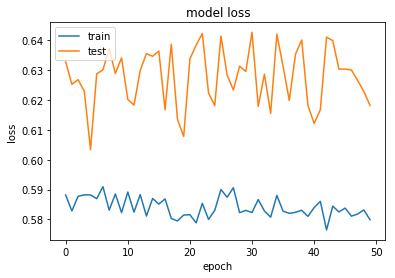

In [135]:
import matplotlib.pyplot as plt
plt.plot(historico3.history['loss'])
plt.plot(historico3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
t = mod_emb.get_layer('vetorizacao')

In [147]:
t.get_weights()[0].shape

(18268, 50)

In [169]:
mod_train.get_layer('emb_layer').set_weights(mod_emb.get_layer('vetorizacao').get_weights())

In [189]:
def create_train_model(vocab_size, story_max_len = 256, emb_dim=50, num_lstm=64, num_relu1=32, num_relu2=16, num_relu3=8):
    input_layer = keras.layers.Input(shape=(story_max_len,), name='input_layer')
    X = keras.layers.Embedding(vocab_size, emb_dim, mask_zero=True, name='emb_layer')(input_layer)
    X = keras.layers.LSTM(num_lstm)(X)
    X = keras.layers.Dropout(0.4)(X)
    X = keras.layers.Dense(num_relu1, activation='relu')(X)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(num_relu2, activation='relu')(X)
    X = keras.layers.Dense(num_relu2, activation='relu')(X)
    output_layer = keras.layers.Dense(1, activation='relu')(X)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

def initialize_train_model(model, emb_weights):
    model.compile(loss='mae',optimizer='adam')
    model.get_layer('emb_layer').set_weights(emb_weights)

mod_train = create_train_model(len(dic))
initialize_train_model(mod_train, mod_emb.get_layer('vetorizacao').get_weights())

In [191]:
save_best = keras.callbacks.ModelCheckpoint('models/train.h5', monitor='val_loss', mode='min', save_best_only=True)
hist_train = mod_train.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[save_best])

Train on 2801 samples, validate on 933 samples
Epoch 1/10
2801/2801 [==============================] - 22s 8ms/step - loss: 9.0253 - val_loss: 6.2359
Epoch 2/10
2801/2801 [==============================] - 23s 8ms/step - loss: 8.5050 - val_loss: 5.9250
Epoch 3/10
2801/2801 [==============================] - 22s 8ms/step - loss: 8.0853 - val_loss: 6.0607
Epoch 4/10
2801/2801 [==============================] - 22s 8ms/step - loss: 7.4871 - val_loss: 6.1678
Epoch 5/10
2801/2801 [==============================] - 22s 8ms/step - loss: 7.2221 - val_loss: 6.0357
Epoch 6/10
2801/2801 [==============================] - 21s 8ms/step - loss: 6.3468 - val_loss: 6.0630
Epoch 7/10
2801/2801 [==============================] - 21s 8ms/step - loss: 5.5445 - val_loss: 6.1631
Epoch 8/10
2801/2801 [==============================] - 21s 8ms/step - loss: 5.1171 - val_loss: 6.0894
Epoch 9/10
2801/2801 [==============================] - 21s 8ms/step - loss: 4.7606 - val_loss: 6.6100
Epoch 10/10
2801/2801 [===

In [172]:
mod_train.evaluate(x_val, y_val)

933/933 [==============================] - 2s 2ms/step


212.65664538539875

In [194]:
mod_train = keras.models.load_model('models/train.h5')

In [195]:
predito = mod_train.predict(x_val)

In [250]:
predito

array([[2.2479343 ],
       [5.5068016 ],
       [6.1625166 ],
       [6.0079937 ],
       [5.7648916 ],
       [0.33027086],
       [1.412546  ],
       [3.8277018 ],
       [5.860844  ],
       [4.619356  ],
       [6.0824385 ],
       [6.007251  ],
       [3.3315358 ],
       [5.6457977 ],
       [3.1196175 ],
       [2.5677874 ],
       [1.056709  ],
       [5.921824  ],
       [5.9003954 ],
       [5.9565983 ],
       [2.8244567 ],
       [2.5625262 ],
       [2.2353    ],
       [3.7661562 ],
       [5.9715652 ],
       [5.7421    ],
       [5.5029097 ],
       [6.340906  ],
       [6.1059475 ],
       [6.0940714 ],
       [5.609194  ],
       [3.1144717 ],
       [5.9863887 ],
       [2.4334645 ],
       [4.2730184 ],
       [6.1046696 ],
       [5.728243  ],
       [4.7947245 ],
       [5.8513436 ],
       [6.0013294 ],
       [6.437192  ],
       [5.918774  ],
       [4.5211277 ],
       [5.430067  ],
       [5.854681  ],
       [6.3503003 ],
       [6.3236227 ],
       [5.964

In [251]:
np.mean(np.abs(predito-y_val))

5.9249587

In [211]:
np.median(train_points)

4.0

In [212]:
np.mean(np.abs(np.mean(y_train)-y_test))

8.668086

In [161]:
import matplotlib.pyplot as plt
plt.plot(hist_train.history['loss'])
plt.plot(hist_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'hist_train' is not defined

In [27]:
class EstimativaConstrastivaRuidosa(keras.layers.Layer):
    def __init__(self, init='glorot_uniform', comprimento=10,
                 dimensao_entrada=None, vocabulario=None, ruidos = 25, distribuicao_ruidos=[0.5, 0.5], semente=19, **kwargs):
        self.init = init
        self.comprimento = comprimento
        self.vocabulario = vocabulario
        self.ruidos = ruidos
        self.distribuicao_ruidos = theano.shared(np.array(distribuicao_ruidos).astype(theano.config.floatX)) #IMP
        self.gerador_aleatorio = theano.tensor.shared_randomstreams.RandomStreams(seed=semente) #IMP
        self.dimensao_entrada = dimensao_entrada
        kwargs['input_shape'] = (self.dimensao_entrada, )
        super(EstimativaConstrastivaRuidosa, self).__init__(**kwargs)

    def build(self, dims_entrada):
        self.W = self.add_weight(name='{}_W'.format(self.name), shape=(self.vocabulario, self.dimensao_entrada), initializer=self.init, trainable=True)
        self.b = self.add_weight(name='{}_b'.format(self.name), shape=(self.vocabulario, )                     , initializer=self.init, trainable=True)
        super(EstimativaConstrastivaRuidosa, self).build(dims_entrada)

    def compute_output_shape(self, dims_entrada):
        return (None, self.comprimento, self.ruidos + 1)
    
    def compute_mask(self, input, mask=None):
        return mask[0]

    def call(self, inputs, mask=None):
        contexto = inputs[0] #shape: amostras * passos * dim
        proxima_palavra = inputs[1] #shape: amostras * passos

        amostras, passos = proxima_palavra.shape
        dim_saida = self.ruidos + 1

        noise_w = self.gerador_aleatorio.choice(size=(amostras, passos, self.ruidos), a=self.distribuicao_ruidos.shape[0], p=self.distribuicao_ruidos)
        proxima_palavra = proxima_palavra.flatten().reshape([amostras, passos, 1])
        proxima_palavra = theano.tensor.concatenate([proxima_palavra, noise_w], axis=-1) #IMP shape: amostras * passos * dim_saida

        W_ = self.W[proxima_palavra.flatten()].flatten().reshape([amostras, passos, dim_saida, self.dimensao_entrada])
        b_ = self.b[proxima_palavra.flatten()].reshape([amostras, passos, dim_saida])

        s_theta = (contexto[:, :, None, :] * W_).sum(axis=-1) + b_ # dims: amostras * passos * dim_saida
        noiseP = self.distribuicao_ruidos[proxima_palavra.flatten()].reshape([amostras, passos, dim_saida])
        noise_score = keras.backend.log(self.ruidos * noiseP) #log(k * distribuicao_ruidos(w))

        return keras.activations.sigmoid(s_theta - noise_score) # dims: amostras, passos, dim_saida

def custo_estimativa_contrastiva(real, estimado):
    custo = K.binary_crossentropy(estimado, real[:, :, 1:])
    custo = custo.sum(axis=-1)
    custo *= real[:, :, 0]
    return K.sum(custo) / K.sum(real[:, :, 0])

def separar_xy_mascara(sequencias, vocabulario=5000, comprimento_maximo=100):
    novas_sequencias = [[palavra if palavra < vocabulario else 0 for p in s] for s in sequencias]

    comprimentos = [min(comprimento_maximo, len(s)-1) for s in sequencias]
    comprimento_maximo = max(comprimentos)
    amostras = numpy.count_nonzero(comprimentos)

    x = numpy.zeros((amostras, comprimento_maximo)).astype('int32')
    y = numpy.zeros((amostras, comprimento_maximo)).astype('int32')
    mascara = numpy.zeros((amostras, comprimento_maximo)).astype('int32')

    idx = 0
    for i, s in enumerate(sequencias):
        l = comprimentos[i]
        if l < 1: continue
        mask[idx, :l] = 1
        x[idx, :l] = s[:l]
        y[idx, :l] = s[1 : l+1]
        x[idx] += mask[idx]
        y[idx] += mask[idx]
        idx += 1

    return x, y, mascara

def calcular_distancias(sequencias, indice_maximo):
    Pn = np.zeros((maxword,))
    for s in sequencias:
        for w in s:
            if w >= indice_maximo: Pn[0] += 1
            else: Pn[w] += 1
    Pn = 1.0 * Pn / sum(Pn)
    return Pn

In [23]:
def modelo_pretreinamento(vocabulario, dim_vetorial, comprimento, ruidos, distribuicao_ruidos):
    entrada_atual = Input(shape=(comprimento,), dtype='int32', name='entrada_atual')
    proxima_entrada = Input(shape=(comprimento,), dtype='int32', name='proxima_entrada')
    vetorizado = Embedding(output_dim=dim_vetorial, input_dim=vocabulario, input_length=comprimento, mask_zero=True)(entrada_atual)
    contexto_recorrente = LSTM(dim_vetorial, input_shape=(None, dim_vetorial), return_sequences=True)(vetorizado)
    estimativa = EstimativaConstrastivaRuidosa(dimensao_entrada=dim_vetorial, comprimento=comprimento, vocabulario=vocabulario,
                ruidos=ruidos, distribuicao_ruidos=distribuicao_ruidos)([contexto_recorrente, proxima_entrada])
    return Model(inputs=[entrada_atual, proxima_entrada], outputs=estimativa)

In [21]:
ruidos = 100
comprimento_maximo = 100
dim_vetorial = 200
vocabulario_maximo = 5000

x_treino, y_treino, mascara_treino = separar_xy_mascara(treino, vocabulario_maximo, comprimento_maximo)

vocabulario_maximo += 1
amostras, comprimento = x_treino.shape
Pn = calcular_distancias(treino, vocabulario_maximo)
masc_treino = numpy.zeros((amostras, comprimento, ruidos + 2), dtype='int64')
masc_treino[:, :, 0] = mascara_treino
masc_treino[:, :, 1] = 1

In [30]:
modelo_pretreino = modelo_pretreinamento(vocabulario_maximo, dim_vetorial, comprimento, ruidos, Pn)

In [31]:
modelo_pretreino.compile(optimizer='adam', loss=custo_estimativa_contrastiva)

In [32]:
historico_pretreino = model.fit([x_treino, y_treino], masc_treino, batch_size=64, epochs=20)

Epoch 1/20
  320/10970 [..............................] - ETA: 6:16 - loss: 16.7152

KeyboardInterrupt: 

In [2]:
import numpy
import theano
from theano import config
import theano.tensor as tensor
import theano.tensor.shared_randomstreams as RS

import keras
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.engine.topology import Layer
from keras.callbacks import *

SEED = 1234

class NCEContext(Layer):
    def __init__(self, init='glorot_uniform', activation='linear',
                 weights=None, input_dim=None, context_dim=None,
                 W_regularizer=None, b_regularizer=None, activity_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=False, **kwargs):
        self.init = initializers.get(init)
        self.activation = activations.get(activation)

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights

        self.input_dim = input_dim
        self.context_dim = context_dim
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)

        super(NCEContext, self).__init__(**kwargs)

    def build(self, input_shape): #input shape: nsamples * n_context * dim
        self.C = self.init((self.context_dim, self.input_dim),
                           name='{}_C'.format(self.name))
        self.trainable_weights = [self.C]

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.input_dim)

    def call(self, x, mask=None):
        #x shape: nsamples * n_context * dim
        #out shape: nsamples * dim
        out = self.C[None, :, :] * x
        out = out.sum(axis=-2)
        return out

    def get_config(self):
        config = {'init': self.init.__name__,
                  'activation': self.activation.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'b_regularizer': self.b_regularizer.get_config() if self.b_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'b_constraint': self.b_constraint.get_config() if self.b_constraint else None,
                  'bias': self.bias,
                  'input_dim': self.input_dim,
                  'context_dim': self.context_dim}
        base_config = super(NCEContext, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class NCE(Layer):
    def __init__(self, init='glorot_uniform', activation='linear',
                 input_dim=None, vocab_size=None, n_noise = 25, Pn=[0.5, 0.5],
                 weights=None,
                 W_regularizer=None, b_regularizer=None, activity_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.init = init #initializers.get(init)
        self.activation = activations.get(activation)
        self.input_dim = input_dim
        self.vocab_size = vocab_size
        self.n_noise = n_noise
        self.Pn = theano.shared(numpy.array(Pn).astype(config.floatX))
        self.rng = RS.RandomStreams(seed=SEED)

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)

        super(NCE, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='{}_W'.format(self.name),
            shape=(self.vocab_size, self.input_dim),
            initializer=self.init,
        )
        #self.init((self.vocab_size, self.input_dim), name='{}_W'.format(self.name))

        if self.bias:
            self.b = self.add_weight(
                name='{}_b'.format(self.name),
                shape=(self.vocab_size,),
                initializer=self.init,
            )
            #self.init((self.vocab_size,), name='{}_b'.format(self.name))
            self.trainable_weights = [self.W, self.b]
        else:
            self.trainable_weights = [self.W]

        self.regularizers = []
        if self.W_regularizer:
            self.W_regularizer.set_param(self.W)
            self.regularizers.append(self.W_regularizer)

        if self.bias and self.b_regularizer:
            self.b_regularizer.set_param(self.b)
            self.regularizers.append(self.b_regularizer)

        if self.activity_regularizer:
            self.activity_regularizer.set_layer(self)
            self.regularizers.append(self.activity_regularizer)

        self.constraints = {}
        if self.W_constraint:
            self.constraints[self.W] = self.W_constraint

        if self.bias and self.b_constraint:
            self.constraints[self.b] = self.b_constraint

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        super(NCE, self).build(input_shape)

    def get_output_shape_for(self, input_shape):
        return (None, self.n_noise + 1)

    def call(self, inputs, mask=None):
        context = inputs[0] #shape: n_samples * dim
        next_w = inputs[1] #shape: n_samles * 1

        n_samples = next_w.shape[0]
        n_next = self.n_noise + 1

        #generate n_noise samples from noise distribution Pn.
        noise_w = self.rng.choice(size=(n_samples, self.n_noise), a=self.Pn.shape[0], p=self.Pn)
        next_w = tensor.concatenate([next_w, noise_w], axis=-1)

        W_ = self.W[next_w.flatten()].flatten().reshape([n_samples, n_next, self.input_dim])
        b_ = self.b[next_w.flatten()].reshape([n_samples, n_next])

        # compute s_theta(w): scores of words under the model
        s_theta = (context[:, None, :] * W_).sum(axis=-1) + b_
        # compute the scores of words under the noise distribution: log(k * Pn(w))
        noiseP = self.Pn[next_w.flatten()].reshape([n_samples, n_next])
        noise_score = K.log(self.n_noise * noiseP)

        # the difference in the scores of words under the model and the noise distribution
        # shape: n_samples * n_next
        out = s_theta - noise_score

        return activations.sigmoid(out)

    def get_config(self):
        config = {'init': self.init,
                  'activation': self.activation.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'b_regularizer': self.b_regularizer.get_config() if self.b_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'b_constraint': self.b_constraint.get_config() if self.b_constraint else None,
                  'bias': self.bias,
                  'input_dim': self.input_dim,
                  'vocab_size': self.vocab_size,
                  'n_noise': self.n_noise
                  }
        base_config = super(NCE, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class NCE_seq(NCE):
    def __init__(self, input_len=10, **kwargs):
        self.input_len = input_len
        super(NCE_seq, self).__init__(**kwargs)

    def compute_mask(self, input, mask=None):
        return mask[0]

    def get_output_shape_for(self, input_shape):
        return (None, self.input_len, self.n_noise + 1)

    def call(self, inputs, mask=None):
        context = inputs[0] #shape: n_samples * n_steps * dim
        next_w = inputs[1] #shape: n_samles * n_steps

        n_samples, n_steps = next_w.shape
        n_next = self.n_noise + 1

        #generate n_noise samples from noise distribution Pn.
        noise_w = self.rng.choice(size=(n_samples, n_steps, self.n_noise), a=self.Pn.shape[0], p=self.Pn)
        next_w = next_w.flatten().reshape([n_samples, n_steps, 1])
        next_w = tensor.concatenate([next_w, noise_w], axis=-1) # shape: n_samples * n_steps * n_next

        W_ = self.W[next_w.flatten()].flatten().reshape([n_samples, n_steps, n_next, self.input_dim])
        b_ = self.b[next_w.flatten()].reshape([n_samples, n_steps, n_next])

        # compute s_theta(w): scores of words under the model
        # s_theta shape: n_samples * n_steps * n_next
        s_theta = (context[:, :, None, :] * W_).sum(axis=-1) + b_
        # compute the scores of words under the noise distribution: log(k * Pn(w))
        noiseP = self.Pn[next_w.flatten()].reshape([n_samples, n_steps, n_next])
        noise_score = K.log(self.n_noise * noiseP)

        # the difference in the scores of words under the model and the noise distribution
        # output shape: n_samples, n_steps, n_next
        out = s_theta - noise_score

        return activations.sigmoid(out)

class NCETest(NCE):
    def get_output_shape_for(self, input_shape):
        return (None, 1)

    def call(self, inputs, mask=None):
        context = inputs[0] # shape: n_samples * dim
        next_w = inputs[1] # shape: n_samples * 1
        n_samples = next_w.shape[0]

        out = K.dot(context, K.transpose(self.W)) + self.b
        out = activations.softmax(out)
        next_w = next_w.flatten()
        return out[tensor.arange(n_samples), next_w]

class NCETest_seq(NCETest):
    def __init__(self, input_len=10, **kwargs):
        self.input_len = input_len
        super(NCETest_seq, self).__init__(**kwargs)

    def get_output_shape_for(self, input_shape):
        return (None, self.input_len)

    def compute_mask(self, input, mask=None):
        return mask[0]

    def call(self, inputs, mask=None):
        context = inputs[0] # shape: n_samples * n_steps * dim
        next_w = inputs[1] # shape: n_samples * n_steps
        n_samples, n_steps = next_w.shape
        vocab_size = self.W.shape[0]

        out = K.dot(context, K.transpose(self.W)) + self.b
        out = activations.softmax(out)
        out = out.flatten().reshape([n_samples*n_steps, vocab_size])
        next_w = next_w.flatten()

        prob = out[tensor.arange(n_samples*n_steps), next_w]
        prob = prob.reshape([n_samples, n_steps])
        return prob

class NCETestCallback(Callback):
    def __init__(self, data, testModel, fResult, fParams, patient=3):
        self.testModel = testModel
        self.fResult = fResult
        self.fParams = fParams
        self.patient = patient
        self.num_patient = patient
        self.best_epoch = 0
        self.best_loss = 100000.0

        self.do_test = False
        if len(data) == 2 or len(data) == 4:
            self.isSeq = 0
            self.valid_x = data[0]
            self.valid_y = data[1]
            self.valid_mask = data[0]

            if len(data) == 4:
                self.do_test = True
                self.test_x = data[2]
                self.test_y = data[3]
                self.test_mask = data[2]

        else:
            self.isSeq = 1
            self.valid_x, self.valid_y, self.valid_mask = data[0], data[1], data[2]
            if len(data) == 6:
                self.do_test = True
                self.test_x, self.test_y, self.test_mask = data[3], data[4], data[5]

        flog = open(fResult, 'w')
        flog.write('epoch\ttr_loss\tv_ppl\n')
        flog.close()
        super(NCETestCallback, self).__init__()

    def _compute_result(self, x, y, mask):
        y_pred = self.testModel.predict([x, y], batch_size=30)
        if self.isSeq:
            per = perplexity(mask, y_pred, 1)
        else:
            per = perplexity(mask, y_pred, 0)
        return per

    def on_epoch_end(self, epoch, logs={}):
        weights = self.model.get_weights()
        self.testModel.set_weights(weights)

        v_per = self._compute_result(self.valid_x, self.valid_y, self.valid_mask)
        if self.do_test:
            t_per = self._compute_result(self.test_x, self.test_y, self.test_mask)

        if self.best_loss < v_per:
            self.patient -= 1

            if self.patient == 0:
                lr = self.model.optimizer.lr / 2.0
                self.model.optimizer.lr = lr
                self.patient = self.num_patient
        else:
            self.patient = self.num_patient
            self.best_loss = v_per
            self.best_epoch = epoch
            self.model.save_weights(self.fParams, overwrite=True)

        print ('validation perplexity: %.4f' % v_per)

        train_loss = 0
        if 'loss' in logs:
            train_loss = logs['loss']

        f = open(self.fResult, 'a')
        f.write('%d\t%.4f\t%.4f' % (epoch, train_loss, v_per))
        if self.do_test:
            f.write('\t%.4f' % t_per)
        f.write('\tBest at epoch %d' % self.best_epoch)
        f.write('\n')
        f.close()

def NCE_seq_loss(y_true, y_pred):
    # y_true[:, :, 0]: masking matrix
    # y_true[:, :, 1] = 1: words from data
    # y_true[:, :, 2:] = 0: words from noise distribution
    # y_pred: probability of the word to be from data - shape: n_samples * n_steps * (n_noise + 1)

    loss = K.binary_crossentropy(y_pred, y_true[:, :, 1:])
    loss = loss.sum(axis=-1)
    loss *= y_true[:, :, 0] # masking matrix
    return K.sum(loss) / K.sum(y_true[:, :, 0])

def NCE_seq_loss_test(y_true, y_pred):
    # y_pred: n_samples * n_steps - probability of next word to be the corresponding word in y_true
    # y_true: masking matrix

    loss = -tensor.log(y_pred)
    loss *= y_true
    loss = K.sum(loss) / K.sum(y_true)
    return K.exp(loss)

def NCE_loss(y_true, y_pred): #n_samples * n_next
    loss = K.binary_crossentropy(y_pred, y_true)
    loss = K.mean(loss.sum(axis=-1))
    return loss

def NCE_loss_test(y_true, y_pred): #(n_samples,)
    loss = - tensor.log(y_pred)
    loss = K.mean(loss)
    loss = K.exp(loss)

    return loss

def perplexity(y_true, y_pred, isSeq = 0): #(n_samples,) or (n_samples, n_steps)
    eps = 1e-4
    loss = - numpy.log(y_pred + eps)

    if isSeq: # sequence
        loss *= y_true
        loss = numpy.sum(loss) / numpy.sum(y_true)
    else:
        loss = numpy.mean(loss)

    loss = numpy.exp(loss)
    return loss


In [3]:
import numpy

def calc_dist(seqs, maxword):
    Pn = numpy.zeros((maxword,))

    for s in seqs:
        for w in s:
            if w >= maxword: Pn[0] += 1
            else: Pn[w] += 1

    Pn = 1.0 * Pn / sum(Pn)

    return Pn

def generate_noise(n_samples, n_noise, Pn):
    noise = numpy.zeros((n_samples, n_noise), dtype='int64')
    for i in range(n_samples):
        noise[i] = numpy.random.choice(len(Pn), n_noise, p=Pn)

    return noise

In [8]:
import gzip
import pickle

def load(path):
    f = gzip.open(path, 'rb')
    train, valid, test = pickle.load(f)
    #print path, len(train[0]), len(valid[0])

    return train, valid, test

def prepare_lm(seqs, vocab_size=10000, max_len=100):
    new_seqs = []
    for i, s in enumerate(seqs):
        new_s = [w if w < vocab_size else 0 for w in s]
        new_seqs.append(new_s)
    seqs = new_seqs

    lengths = [min(max_len, len(s)-1) for s in seqs]
    maxlen = max(lengths)
    n_samples = numpy.count_nonzero(lengths)

    x = numpy.zeros((n_samples, maxlen)).astype('int64')
    y = numpy.zeros((n_samples, maxlen)).astype('int64')
    mask = numpy.zeros((n_samples, maxlen)).astype('int64')

    idx = 0
    for i, s in enumerate(seqs):
        l = lengths[i]
        if l < 1: continue
        mask[idx, :l] = 1
        x[idx, :l] = s[:l]
        y[idx, :l] = s[1 : l+1]
        x[idx] += mask[idx]
        y[idx] += mask[idx]
        idx += 1

    return x, y, mask


In [5]:
from keras.layers import *
from keras.models import Model
from keras.constraints import *
from keras.regularizers import *
import numpy

dataset = 'dados/pretreino/moodle_pretrain.pkl.gz'
emb_dim = 200
max_len = 100

n_noise = 100
print ('Loading data...')
train, valid, test = load(dataset)
valid = valid[-5000:]
vocab_size = 5000

print ('vocab: ', vocab_size)

train_x, train_y, train_mask = prepare_lm(train, vocab_size, max_len)
valid_x, valid_y, valid_mask = prepare_lm(valid, vocab_size, max_len)

print ('Data size: Train: %d, valid: %d' % (len(train_x), len(valid_x)))

vocab_size += 1
n_samples, inp_len = train_x.shape
Pn = calc_dist(train, vocab_size)
labels = numpy.zeros((n_samples, inp_len, n_noise + 2), dtype='int64')
labels[:, :, 0] = train_mask
labels[:, :, 1] = 1

main_inp = Input(shape=(inp_len,), dtype='int64', name='main_inp')
next_inp = Input(shape=(inp_len,), dtype='int64', name='next_inp')
emb_vec = Embedding(output_dim=emb_dim, input_dim=vocab_size, input_length=inp_len,
                    #dropout=0.2,
                    mask_zero=True)(main_inp)
GRU_context = LSTM(emb_dim, input_shape=(None, emb_dim), return_sequences=True)(emb_vec)
nce_out = NCE_seq(input_dim=emb_dim, input_len=inp_len, vocab_size=vocab_size, n_noise=n_noise, Pn=Pn,
              )([GRU_context, next_inp])
model = Model(inputs=[main_inp, next_inp], outputs=[nce_out])
optimizer = RMSprop(lr=0.02, rho=0.99, epsilon=1e-7) #optimizer = RMSprop(lr=0.01)
model.compile(optimizer=optimizer, loss=NCE_seq_loss)
print(model.summary())
his = model.fit([train_x, train_y], labels,
          batch_size=50, epochs=20)

Loading data...
vocab:  5000
Data size: Train: 67794, valid: 4869


/usr/lib64/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_inp (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 200)     1000200     main_inp[0][0]                   
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100, 200)     320800      embedding_1[0][0]                
__________________________________________________________________________________________________
next_inp (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
nce_seq_1 

KeyboardInterrupt: 

In [7]:
Pn.shape

(5001,)

## Treinamento

In [ ]:
def modelo_treinamento(n_classes, vocab_size, inp_len, emb_dim,
                 seq_model='lstm', nnet_model='highway', pool_mode='mean',
                 dropout_inp=False, dropout_hid=True, emb_weight=None, hidden_layer=None):
    if emb_weight is not None:
        emb_weight = [emb_weight[:vocab_size]]
    seq_dict = {'lstm': LSTM, 'gru': GRU, 'rnn': SimpleRNN}
    nnet_dict = {'highway': create_highway, 'dense': create_dense}
    if n_classes == -1:
        top_act = 'linear'
    elif n_classes == 1:
        top_act = 'sigmoid'
    else:
        top_act = 'softmax'

    title_inp = Input(shape=(inp_len,), dtype='int64', name='title_inp')
    descr_inp = Input(shape=(inp_len,), dtype='int64', name='descr_inp')

    title_mask = Input(shape=(inp_len,), dtype='float32', name='title_mask')
    descr_mask = Input(shape=(inp_len,), dtype='float32', name='descr_mask')

    if dropout_inp:
        drop_rate = 0.2
    else:
        drop_rate = 0.0

    embedding = Embedding(output_dim=emb_dim, input_dim=vocab_size, input_length=inp_len,
                          mask_zero=True, weights=emb_weight,
                          dropout=drop_rate)
    seq_layer = seq_dict[seq_model](input_dim=emb_dim, output_dim=emb_dim,
                                    return_sequences=True, dropout_U=drop_rate, dropout_W=drop_rate)

    title_emb = embedding(title_inp)
    descr_emb = embedding(descr_inp)

    title_hid = seq_layer(title_emb)
    descr_hid = seq_layer(descr_emb)

    pooled_title = PoolingSeq(mode=pool_mode)([title_hid, title_mask])
    pooled_descr = PoolingSeq(mode=pool_mode)([descr_hid, descr_mask])

    hidd = Average()([pooled_title, pooled_descr])
    if dropout_hid:
        hidd = Dropout(0.5)(hidd)

    hidd = nnet_dict[nnet_model](hidd, emb_dim, hidden_layer)
    hidd = Dropout(0.5)(hidd)
    top_hidd = Dense(output_dim=abs(n_classes), activation=top_act)(hidd)

    model = Model(input=[title_inp, title_mask, descr_inp, descr_mask], output=top_hidd)

    return model

## Avaliação

In [2]:
'''
#This example demonstrates the use of fasttext for text classification
Based on Joulin et al's paper:
[Bags of Tricks for Efficient Text Classification
](https://arxiv.org/abs/1607.01759)
Results on IMDB datasets with uni and bi-gram embeddings:
Embedding|Accuracy, 5 epochs|Speed (s/epoch)|Hardware
:--------|-----------------:|----:|:-------
Uni-gram |            0.8813|    8|i7 CPU
Bi-gram  |            0.9056|    2|GTx 980M GPU
'''

from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(
    np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(
    np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238
Average test sequence length: 230
Adding 2-gram features
Average train sequence length: 476
Average test sequence length: 428
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 45s 2ms/step - loss: 0.5862 - acc: 0.7874 - val_loss: 0.4372 - val_acc: 0.8548
Epoch 2/5
25000/25000 [==============================] - 34s 1ms/step - loss: 0.2877 - acc: 0.9276 - val_loss: 0.3030 - val_acc: 0.8904
Epoch 3/5
25000/25000 [==============================] - 34s 1ms/step - loss: 0.1432 - acc: 0.9696 - val_loss: 0.2628 - val_acc: 0.8998
Epoch 4/5
25000/25000 [==============================] - 34s 1ms/step - loss: 0.0775 - acc: 0.9871 - val_loss: 0.2441 - val_acc: 0.9030
Epoch 5/5
25000/25000 [==============================] - 34s 1ms/step - loss: 0.0437 

In [23]:
imdb.np

<module 'numpy' from '/usr/lib64/python3.6/site-packages/numpy/__init__.py'>

In [14]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant


BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove_en')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
validation_data=(x_val, y_val))

Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
Found 19997 texts.
Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
Preparing embedding matrix.
Training model.
Train on 15998 samples, validate on 3999 samples
Epoch 1/10
15998/15998 [==============================] - 5s 340us/step - loss: 2.4037 - acc: 0.2187 - val_loss: 1.8067 - val_acc: 0.3768
Epoch 2/10
15998/15998 [==============================] - 4s 276us/step - loss: 1.5519 - acc: 0.4621 - val_loss: 1.4603 - val_acc: 0.5064
Epoch 3/10
15998/15998 [==============================] - 4s 276us/step - loss: 1.1902 - acc: 0.5953 - val_loss: 1.1682 - val_acc: 0.5969
Epoch 4/10
15998/15998 [==============================] - 4s 276us/step - loss: 0.9690 - acc: 0.6748 - val_loss: 1.0070 - val_acc: 0.6624
Epoch 5/10
15998/15998 [==============================] - 4s 276us/step - loss: 0.8137 - acc: 0.7250 - val_loss: 0.9541 - val_acc: 0.6784
Epoch 6/10
15998/15998 [=

In [30]:
'''Trains and evaluate a simple MLP
on the Reuters newswire topic classification task.
'''
from __future__ import print_function

import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer

max_words = 1000
batch_size = 64
epochs = 50

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('Building model...')
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Loading data...
8982 train sequences
2246 test sequences
46 classes
Vectorizing sequence data...
x_train shape: (8982, 1000)
x_test shape: (2246, 1000)
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (8982, 46)
y_test shape: (2246, 46)
Building model...
Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 0s 24us/step - loss: 1.5670 - acc: 0.6538 - val_loss: 1.1814 - val_acc: 0.7442
Epoch 2/50
8083/8083 [==============================] - 0s 24us/step - loss: 0.8898 - acc: 0.7982 - val_loss: 0.9999 - val_acc: 0.7798
Epoch 3/50
8083/8083 [==============================] - 0s 24us/step - loss: 0.6416 - acc: 0.8458 - val_loss: 0.8985 - val_acc: 0.7875
Epoch 4/50
8083/8083 [==============================] - 0s 24us/step - loss: 0.4929 - acc: 0.8820 - val_loss: 0.8817 - val_acc: 0.8031
Epoch 5/50
8083/8083 [==============================] - 0s 24us/step - loss: 0.3945 - acc: 0.9042 - val_loss

In [31]:
# -*- coding: utf-8 -*-
'''
# An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be reversed, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits reversed:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits reversed:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits reversed:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits reversed:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs
'''  # noqa

from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range


class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
print(guess)

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 1
Train on 45000 samples, validat

45000/45000 [==============================] - 5s 101us/step - loss: 0.2601 - acc: 0.9329 - val_loss: 0.2259 - val_acc: 0.9476
Q 31+209  T 240  ☑ Q 800+952 T 1752 ☒ Q 795+24  T 819  ☑ Q 674+668 T 1342 ☑ Q 63+85   T 148  ☑ Q 834+409 T 1243 ☑ Q 292+700 T 992  ☑ Q 8+629   T 637  ☑ Q 764+282 T 1046 ☑ Q 85+187  T 272  ☑ 
--------------------------------------------------
Iteration 16
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.1878 - acc: 0.9603 - val_loss: 0.1780 - val_acc: 0.9577
Q 773+511 T 1284 ☑ Q 336+527 T 863  ☑ Q 755+30  T 785  ☑ Q 32+724  T 756  ☑ Q 773+4   T 777  ☑ Q 2+42    T 44   ☑ Q 998+21  T 1019 ☑ Q 698+676 T 1374 ☒ Q 238+80  T 318  ☑ Q 73+60   T 133  ☑ 
--------------------------------------------------
Iteration 17
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.1460 - acc: 0.9711 - val_loss: 0.1520 - val_acc

45000/45000 [==============================] - 5s 101us/step - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0055 - val_acc: 0.9991
Q 760+714 T 1474 ☑ Q 321+21  T 342  ☑ Q 946+14  T 960  ☑ Q 1+829   T 830  ☑ Q 803+630 T 1433 ☑ Q 11+872  T 883  ☑ Q 77+796  T 873  ☑ Q 450+559 T 1009 ☑ Q 779+416 T 1195 ☑ Q 95+984  T 1079 ☑ 
--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.0029 - acc: 0.9999 - val_loss: 0.0073 - val_acc: 0.9981
Q 228+10  T 238  ☑ Q 892+845 T 1737 ☑ Q 359+91  T 450  ☑ Q 27+105  T 132  ☑ Q 53+222  T 275  ☑ Q 812+74  T 886  ☑ Q 7+908   T 915  ☑ Q 643+498 T 1141 ☑ Q 649+13  T 662  ☑ Q 243+639 T 882  ☑ 
--------------------------------------------------
Iteration 48
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0050 - val_acc

45000/45000 [==============================] - 5s 100us/step - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0039 - val_acc: 0.9997
Q 6+416   T 422  ☑ Q 243+880 T 1123 ☑ Q 280+97  T 377  ☑ Q 959+9   T 968  ☑ Q 46+49   T 95   ☑ Q 6+145   T 151  ☑ Q 19+645  T 664  ☑ Q 22+15   T 37   ☑ Q 585+973 T 1558 ☑ Q 56+515  T 571  ☑ 
--------------------------------------------------
Iteration 63
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 100us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 0.9997
Q 27+1    T 28   ☑ Q 616+766 T 1382 ☑ Q 621+75  T 696  ☑ Q 78+408  T 486  ☑ Q 94+186  T 280  ☑ Q 708+304 T 1012 ☑ Q 616+3   T 619  ☑ Q 891+8   T 899  ☑ Q 406+4   T 410  ☑ Q 58+629  T 687  ☑ 
--------------------------------------------------
Iteration 64
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0031 - val_acc

45000/45000 [==============================] - 5s 101us/step - loss: 5.8933e-04 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 0.9995
Q 1+518   T 519  ☑ Q 874+342 T 1216 ☑ Q 774+807 T 1581 ☑ Q 5+568   T 573  ☑ Q 88+65   T 153  ☑ Q 803+14  T 817  ☑ Q 622+814 T 1436 ☑ Q 227+603 T 830  ☑ Q 695+50  T 745  ☑ Q 880+54  T 934  ☑ 
--------------------------------------------------
Iteration 94
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 101us/step - loss: 0.0130 - acc: 0.9964 - val_loss: 0.1569 - val_acc: 0.9524
Q 59+463  T 522  ☑ Q 103+74  T 177  ☑ Q 526+398 T 924  ☑ Q 418+23  T 441  ☑ Q 275+11  T 286  ☑ Q 952+17  T 969  ☑ Q 82+112  T 194  ☑ Q 853+621 T 1474 ☒ Q 229+815 T 1044 ☑ Q 218+511 T 729  ☑ 
--------------------------------------------------
Iteration 95
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 100us/step - loss: 0.0231 - acc: 0.9932 - val_loss: 0.0040 - val

45000/45000 [==============================] - 5s 101us/step - loss: 3.7567e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 0.9997
Q 463+497 T 960  ☑ Q 620+5   T 625  ☑ Q 804+0   T 804  ☑ Q 73+353  T 426  ☑ Q 63+43   T 106  ☑ Q 86+155  T 241  ☑ Q 27+1    T 28   ☑ Q 978+27  T 1005 ☑ Q 400+597 T 997  ☑ Q 85+605  T 690  ☑ 
--------------------------------------------------
Iteration 125
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 100us/step - loss: 3.3243e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 0.9997
Q 9+800   T 809  ☑ Q 772+860 T 1632 ☑ Q 123+87  T 210  ☑ Q 91+605  T 696  ☑ Q 14+10   T 24   ☑ Q 25+960  T 985  ☑ Q 410+37  T 447  ☑ Q 88+85   T 173  ☑ Q 435+34  T 469  ☑ Q 961+828 T 1789 ☑ 
--------------------------------------------------
Iteration 126
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 4.9742e-04 - acc: 0.9999 - val_loss: 0.

45000/45000 [==============================] - 5s 100us/step - loss: 5.7683e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 0.9996
Q 275+6   T 281  ☑ Q 72+55   T 127  ☑ Q 453+44  T 497  ☑ Q 12+392  T 404  ☑ Q 30+302  T 332  ☑ Q 350+496 T 846  ☑ Q 588+367 T 955  ☑ Q 81+308  T 389  ☑ Q 300+58  T 358  ☑ Q 669+409 T 1078 ☑ 
--------------------------------------------------
Iteration 141
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 6.4655e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 0.9996
Q 53+22   T 75   ☑ Q 752+261 T 1013 ☑ Q 679+3   T 682  ☑ Q 650+998 T 1648 ☑ Q 679+192 T 871  ☑ Q 863+601 T 1464 ☑ Q 3+94    T 97   ☑ Q 964+110 T 1074 ☑ Q 171+23  T 194  ☑ Q 107+50  T 157  ☑ 
--------------------------------------------------
Iteration 142
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 3.5080e-04 - acc: 1.0000 - val_loss: 0.

45000/45000 [==============================] - 4s 100us/step - loss: 2.0895e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9996
Q 837+664 T 1501 ☑ Q 6+150   T 156  ☑ Q 90+901  T 991  ☑ Q 2+424   T 426  ☑ Q 113+351 T 464  ☑ Q 6+521   T 527  ☑ Q 178+80  T 258  ☑ Q 87+35   T 122  ☑ Q 290+37  T 327  ☑ Q 3+983   T 986  ☑ 
--------------------------------------------------
Iteration 157
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 1.8735e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9995
Q 583+62  T 645  ☑ Q 269+860 T 1129 ☑ Q 690+91  T 781  ☑ Q 8+712   T 720  ☑ Q 72+923  T 995  ☑ Q 78+874  T 952  ☑ Q 976+652 T 1628 ☑ Q 221+46  T 267  ☑ Q 888+5   T 893  ☑ Q 99+946  T 1045 ☑ 
--------------------------------------------------
Iteration 158
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 1.7021e-04 - acc: 1.0000 - val_loss: 0.

45000/45000 [==============================] - 4s 100us/step - loss: 4.1313e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 0.9996
Q 32+237  T 269  ☑ Q 34+254  T 288  ☑ Q 15+35   T 50   ☑ Q 859+814 T 1673 ☑ Q 24+620  T 644  ☑ Q 782+79  T 861  ☑ Q 183+61  T 244  ☑ Q 488+23  T 511  ☑ Q 679+713 T 1392 ☑ Q 520+224 T 744  ☑ 
--------------------------------------------------
Iteration 173
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 5s 100us/step - loss: 3.0820e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9997
Q 564+696 T 1260 ☑ Q 12+475  T 487  ☑ Q 802+3   T 805  ☑ Q 528+116 T 644  ☑ Q 35+342  T 377  ☑ Q 75+330  T 405  ☑ Q 509+36  T 545  ☑ Q 624+76  T 700  ☑ Q 90+669  T 759  ☑ Q 4+346   T 350  ☑ 
--------------------------------------------------
Iteration 174
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 2.5728e-04 - acc: 1.0000 - val_loss: 0.

45000/45000 [==============================] - 4s 100us/step - loss: 1.8462e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9996
Q 717+42  T 759  ☑ Q 76+49   T 125  ☑ Q 0+606   T 606  ☑ Q 79+934  T 1013 ☑ Q 6+625   T 631  ☑ Q 83+0    T 83   ☑ Q 63+57   T 120  ☑ Q 405+7   T 412  ☑ Q 42+280  T 322  ☑ Q 12+541  T 553  ☑ 
--------------------------------------------------
Iteration 189
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 100us/step - loss: 1.6379e-04 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 0.9996
Q 59+512  T 571  ☑ Q 72+82   T 154  ☑ Q 21+388  T 409  ☑ Q 16+59   T 75   ☑ Q 326+221 T 547  ☑ Q 803+521 T 1324 ☑ Q 55+737  T 792  ☑ Q 2+548   T 550  ☑ Q 66+591  T 657  ☑ Q 330+681 T 1011 ☑ 
--------------------------------------------------
Iteration 190
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 4s 99us/step - loss: 1.4627e-04 - acc: 1.0000 - val_loss: 0.0

In [32]:
'''
# Trains two recurrent neural networks based upon a story and a question.
The resulting merged vector is then queried to answer a range of bAbI tasks.
The results are comparable to those for an LSTM model provided in Weston et al.:
"Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks"
http://arxiv.org/abs/1502.05698
Task Number                  | FB LSTM Baseline | Keras QA
---                          | ---              | ---
QA1 - Single Supporting Fact | 50               | 52.1
QA2 - Two Supporting Facts   | 20               | 37.0
QA3 - Three Supporting Facts | 20               | 20.5
QA4 - Two Arg. Relations     | 61               | 62.9
QA5 - Three Arg. Relations   | 70               | 61.9
QA6 - yes/No Questions       | 48               | 50.7
QA7 - Counting               | 49               | 78.9
QA8 - Lists/Sets             | 45               | 77.2
QA9 - Simple Negation        | 64               | 64.0
QA10 - Indefinite Knowledge  | 44               | 47.7
QA11 - Basic Coreference     | 72               | 74.9
QA12 - Conjunction           | 74               | 76.4
QA13 - Compound Coreference  | 94               | 94.4
QA14 - Time Reasoning        | 27               | 34.8
QA15 - Basic Deduction       | 21               | 32.4
QA16 - Basic Induction       | 23               | 50.6
QA17 - Positional Reasoning  | 51               | 49.1
QA18 - Size Reasoning        | 52               | 90.8
QA19 - Path Finding          | 8                | 9.0
QA20 - Agent's Motivations   | 91               | 90.7
For the resources related to the bAbI project, refer to:
https://research.facebook.com/researchers/1543934539189348
### Notes
- With default word, sentence, and query vector sizes, the GRU model achieves:
  - 52.1% test accuracy on QA1 in 20 epochs (2 seconds per epoch on CPU)
  - 37.0% test accuracy on QA2 in 20 epochs (16 seconds per epoch on CPU)
In comparison, the Facebook paper achieves 50% and 20% for the LSTM baseline.
- The task does not traditionally parse the question separately. This likely
improves accuracy and is a good example of merging two RNNs.
- The word vector embeddings are not shared between the story and question RNNs.
- See how the accuracy changes given 10,000 training samples (en-10k) instead
of only 1000. 1000 was used in order to be comparable to the original paper.
- Experiment with GRU, LSTM, and JZS1-3 as they give subtly different results.
- The length and noise (i.e. 'useless' story components) impact the ability of
LSTMs / GRUs to provide the correct answer. Given only the supporting facts,
these RNNs can achieve 100% accuracy on many tasks. Memory networks and neural
networks that use attentional processes can efficiently search through this
noise to find the relevant statements, improving performance substantially.
This becomes especially obvious on QA2 and QA3, both far longer than QA1.
'''

from __future__ import print_function
from functools import reduce
import re
import tarfile

import numpy as np

from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import recurrent
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences


def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true,
    only the sentences that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file, retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))

RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 20
print('RNN / Embed / Sent / Query = {}, {}, {}, {}'.format(RNN,
                                                           EMBED_HIDDEN_SIZE,
                                                           SENT_HIDDEN_SIZE,
                                                           QUERY_HIDDEN_SIZE))

try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

# Default QA1 with 1000 samples
# challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
# QA1 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA2 with 1000 samples
challenge = 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt'
# QA2 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'
with tarfile.open(path) as tar:
    train = get_stories(tar.extractfile(challenge.format('train')))
    test = get_stories(tar.extractfile(challenge.format('test')))

vocab = set()
for story, q, answer in train + test:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train + test)))
query_maxlen = max(map(len, (x for _, x, _ in train + test)))

x, xq, y = vectorize_stories(train, word_idx, story_maxlen, query_maxlen)
tx, txq, ty = vectorize_stories(test, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
print('x.shape = {}'.format(x.shape))
print('xq.shape = {}'.format(xq.shape))
print('y.shape = {}'.format(y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))

print('Build model...')

sentence = layers.Input(shape=(story_maxlen,), dtype='int32')
encoded_sentence = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(sentence)
encoded_sentence = RNN(SENT_HIDDEN_SIZE)(encoded_sentence)

question = layers.Input(shape=(query_maxlen,), dtype='int32')
encoded_question = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(question)
encoded_question = RNN(QUERY_HIDDEN_SIZE)(encoded_question)

merged = layers.concatenate([encoded_sentence, encoded_question])
preds = layers.Dense(vocab_size, activation='softmax')(merged)

model = Model([sentence, question], preds)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Training')
model.fit([x, xq], y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.05)

print('Evaluation')
loss, acc = model.evaluate([tx, txq], ty,
                           batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

RNN / Embed / Sent / Query = <class 'keras.layers.recurrent.LSTM'>, 50, 100, 100
11747328/11745123 [==============================] - 12s 1us/step


/usr/lib64/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


vocab = ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'apple', 'back', 'bathroom', 'bedroom', 'discarded', 'down', 'dropped', 'football', 'garden', 'got', 'grabbed', 'hallway', 'is', 'journeyed', 'kitchen', 'left', 'milk', 'moved', 'office', 'picked', 'put', 'the', 'there', 'to', 'took', 'travelled', 'up', 'went']
x.shape = (1000, 552)
xq.shape = (1000, 5)
y.shape = (1000, 36)
story_maxlen, query_maxlen = 552, 5
Build model...
Training
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 14s 15ms/step - loss: 2.6727 - acc: 0.1989 - val_loss: 1.7922 - val_acc: 0.3000
Epoch 2/20
950/950 [==============================] - 14s 14ms/step - loss: 1.8014 - acc: 0.2242 - val_loss: 1.7732 - val_acc: 0.3000
Epoch 3/20
950/950 [==============================] - 14s 14ms/step - loss: 1.7899 - acc: 0.1874 - val_loss: 1.8582 - val_acc: 0.0600
Epoch 4/20
950/950 [==============================] - 14s 14ms/step - loss: 1.8010 - acc: 0.2042 - val_

In [22]:
'''
#This example demonstrates the use of Convolution1D for text classification.
Gets to 0.89 test accuracy after 2 epochs. </br>
90s/epoch on Intel i5 2.4Ghz CPU. </br>
10s/epoch on Tesla K40 GPU.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 5s 207us/step - loss: 0.4117 - acc: 0.7925 - val_loss: 0.2960 - val_acc: 0.8726
Epoch 2/10
25000/25000 [==============================] - 5s 204us/step - loss: 0.2309 - acc: 0.9072 - val_loss: 0.2960 - val_acc: 0.8762
Epoch 3/10
25000/25000 [==============================] - 5s 205us/step - loss: 0.1687 - acc: 0.9349 - val_loss: 0.2719 - val_acc: 0.8900
Epoch 4/10
25000/25000 [==============================] - 5s 203us/step - loss: 0.1195 - acc: 0.9569 - val_loss: 0.3363 - val_acc: 0.8826
Epoch 5/10
25000/25000 [==============================] - 5s 203us/step - loss: 0.0785 - acc: 0.9716 - val_loss: 0.3456 - val_acc: 0.8856
Epoch 6/10
25000/25000 [==============================] - 5s 203us/step - loss: 0.0593 - acc: 0.9787